## Preprocessing

In [ ]:
!pip install transformers torch

Note: you may need to restart the kernel to use updated packages.


In [1]:
#IMPORTS
import pandas as pd
import numpy as np

In [2]:
with open('transcript.txt', 'r') as file:
    transcript = [line.strip() for line in file if line.strip() != '']

In [3]:
import pandas as pd

# Split each line at the first colon
data = []
for line in transcript:
    if ':' in line:
        speaker, text = line.split(':', 1)
        text = text.lstrip()  # Remove leading space
        data.append([speaker, text])
    else:
        data.append(['', line])

transcript_df = pd.DataFrame(data, columns=['Speaker', 'Text'])
transcript_df.head()

,Speaker,Text
0,DAVID MUIR,"Tonight, the high-stakes showdown here in Phil..."
1,LINSEY DAVIS,A historic race for president upended just wee...
2,DAVID MUIR,The candidates separated by the smallest of ma...
3,DAVID MUIR,"Good evening, I'm David Muir. And thank you fo..."
4,LINSEY DAVIS,And I'm Linsey Davis. Tonight's meeting could ...


In [4]:
transcript_df.describe(include='all')

,Speaker,Text
count,221,221
unique,7,212
top,FORMER PRESIDENT DONALD TRUMP,"Vice President Harris, thank you."
freq,75,4


In [5]:
transcript_df.groupby('Speaker').count()

,Text
Speaker,
DAVID MUIR,74
FORMER PRESIDENT DONALD TRUMP,75
LINDSEY DAVIS,1
LINSEY DAVIS,35
PRESIDENT TRUMP,1
VICE PRESIDENT HARRIS,1
VICE PRESIDENT KAMALA HARRIS,34


In [6]:
def fix_speaker_label(speaker):
    if speaker=="VICE PRESIDENT HARRIS":
        return "VICE PRESIDENT KAMALA HARRIS"
    elif speaker=="PRESIDENT TRUMP":
        return "FORMER PRESIDENT DONALD TRUMP"
    elif speaker=="LINDSEY DAVIS":
        return "LINSEY DAVIS"
    else:
        return speaker
    
transcript_df['Speaker'] = transcript_df['Speaker'].apply(fix_speaker_label)
transcript_df['Speaker'].unique()

array(['DAVID MUIR', 'LINSEY DAVIS', 'VICE PRESIDENT KAMALA HARRIS',
       'FORMER PRESIDENT DONALD TRUMP'], dtype=object)

## First Test - BERT

In [7]:
#!pip install pandas nltk transformers torch

In [8]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

In [9]:
# === BERT Setup ===
model_name = "textattack/bert-base-uncased-SST-2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

def analyze_bert(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    with torch.no_grad():
        logits = model(**inputs).logits
    probs = torch.nn.functional.softmax(logits, dim=-1).squeeze().numpy()
    return float(probs[1])  # Probability of positive sentiment

transcript_df["BERT_Positive_Prob"] = transcript_df["Text"].apply(analyze_bert)

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

c:\Users\LucaGio\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\LucaGio\.cache\huggingface\hub\models--textattack--bert-base-uncased-SST-2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [10]:
def transform_bert_to_sentiment(prob):
    return 2*(prob) - 1  # Transform to range [-1, 1]
transcript_df["BERT_Sentiment"] = transcript_df["BERT_Positive_Prob"].apply(transform_bert_to_sentiment)

In [11]:
transcript_df.sort_values(by="BERT_Positive_Prob", ascending=True, inplace=True)
transcript_df.head(10)

,Speaker,Text,BERT_Positive_Prob,BERT_Sentiment
32,FORMER PRESIDENT DONALD TRUMP,"Well, bad immigration is the worst thing that ...",0.001828,-0.996344
200,LINSEY DAVIS,"So just a yes or no, you still do not have a p...",0.001876,-0.996247
98,VICE PRESIDENT KAMALA HARRIS,"That's not true. [mouthed, not audible]",0.001963,-0.996075
57,VICE PRESIDENT KAMALA HARRIS,That's not true.,0.001999,-0.996002
181,FORMER PRESIDENT DONALD TRUMP,And these people did the worst withdrawal and ...,0.002611,-0.994777
103,FORMER PRESIDENT DONALD TRUMP,These are not good things for the environment ...,0.002761,-0.994479
125,FORMER PRESIDENT DONALD TRUMP,Our elections are bad. And a lot of these ille...,0.003592,-0.992816
83,FORMER PRESIDENT DONALD TRUMP,"use me, the FBI -- they were defrauding statem...",0.003897,-0.992205
92,FORMER PRESIDENT DONALD TRUMP,This is the one that weaponized. Not me. She w...,0.003968,-0.992063
71,FORMER PRESIDENT DONALD TRUMP,But the people on television say their dog was...,0.004264,-0.991473


In [12]:
transcript_df.groupby('Speaker').agg({
    'BERT_Sentiment': ['mean', 'std', 'min', 'max'],
    'Text': lambda x: ' '.join(x)
}).reset_index().rename(columns={'Text': 'Combined_Text'}).head(10)

Speaker BERT_Sentiment                                \
                                           mean       std       min       max   
0                     DAVID MUIR       0.269357  0.751267 -0.990639  0.997411   
1  FORMER PRESIDENT DONALD TRUMP      -0.447721  0.754470 -0.996344  0.999003   
2                   LINSEY DAVIS       0.293715  0.847851 -0.996247  0.999279   
3   VICE PRESIDENT KAMALA HARRIS      -0.212409  0.853250 -0.996075  0.997138   

                                       Combined_Text  
                                            <lambda>  
0  Again, the Springfield city manager says there...  
1  Well, bad immigration is the worst thing that ...  
2  So just a yes or no, you still do not have a p...  
3  That's not true. [mouthed, not audible] That's...

## First Test - Vader

In [13]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\LucaGio\AppData\Roaming\nltk_data...


True

In [14]:
# === VADER Setup ===
vader = SentimentIntensityAnalyzer()

def analyze_vader(text):
    scores = vader.polarity_scores(text)
    return scores['compound']  # Main sentiment score [-1, 1]

transcript_df["VADER_Score"] = transcript_df["Text"].apply(analyze_vader)


In [15]:
transcript_df.sort_values(by="VADER_Score", ascending=True, inplace=True)
transcript_df.head(10)

,Speaker,Text,BERT_Positive_Prob,BERT_Sentiment,VADER_Score
140,FORMER PRESIDENT DONALD TRUMP,If I were president it would have never starte...,0.028739,-0.942522,-0.9927
81,FORMER PRESIDENT DONALD TRUMP,Yeah. It is much higher because of them. They ...,0.013873,-0.972253,-0.9920
106,FORMER PRESIDENT DONALD TRUMP,You just said a thing that isn't covered. Peac...,0.016225,-0.967550,-0.9888
164,FORMER PRESIDENT DONALD TRUMP,"Quiet, please. He would have been sitting in M...",0.066428,-0.867145,-0.9866
176,VICE PRESIDENT KAMALA HARRIS,"Well, I will tell you, I agreed with President...",0.013092,-0.973817,-0.9861
218,FORMER PRESIDENT DONALD TRUMP,"So, she just started by saying she's going to ...",0.245051,-0.509899,-0.9839
133,FORMER PRESIDENT DONALD TRUMP,Let me just tell you about world leaders. Vikt...,0.080269,-0.839463,-0.9788
150,FORMER PRESIDENT DONALD TRUMP,I want the war to stop. I want to save lives t...,0.025549,-0.948902,-0.9726
190,FORMER PRESIDENT DONALD TRUMP,This is the most divisive presidency in the hi...,0.010642,-0.978717,-0.9688
61,VICE PRESIDENT KAMALA HARRIS,So I'm the only person on this stage who has p...,0.961460,0.922920,-0.9538


In [16]:
#Biggest difference between VADER and BERT
transcript_df["VADER_BERT_Difference"] = transcript_df["VADER_Score"] - transcript_df["BERT_Sentiment"]
transcript_df.sort_values(by="VADER_BERT_Difference", ascending=False, inplace=True)
transcript_df

,Speaker,Text,BERT_Positive_Prob,BERT_Sentiment,VADER_Score,VADER_BERT_Difference
24,FORMER PRESIDENT DONALD TRUMP,That's just a sound bite. They gave her that t...,0.005355,-0.989289,0.9726,1.961889
46,FORMER PRESIDENT DONALD TRUMP,"Well, I didn't discuss it with JD In all fairn...",0.013458,-0.973084,0.9357,1.908784
48,VICE PRESIDENT KAMALA HARRIS,I absolutely support reinstating the protectio...,0.016426,-0.967148,0.9249,1.892048
177,VICE PRESIDENT KAMALA HARRIS,"And get this -- no, get this. And the presiden...",0.038538,-0.922924,0.9527,1.875624
97,FORMER PRESIDENT DONALD TRUMP,"Well, first of all, I wasn't given $400 millio...",0.037093,-0.925813,0.9374,1.863213
...,...,...,...,...,...,...
0,DAVID MUIR,"Tonight, the high-stakes showdown here in Phil...",0.997761,0.995523,0.0000,-0.995523
174,FORMER PRESIDENT DONALD TRUMP,Otherwise we would've never gotten it. He said...,0.998436,0.996871,0.0000,-0.996871
5,DAVID MUIR,And that brings us to the rules of tonight's d...,0.972457,0.944915,-0.4939,-1.438815
128,DAVID MUIR,And said there was no widespread fraud.,0.919051,0.838102,-0.7184,-1.556502


In [17]:
transcript_df.groupby('Speaker').agg({
    'VADER_Score': ['mean', 'std', 'min', 'max'],
    'Text': lambda x: ' '.join(x)
}).reset_index().rename(columns={'Text': 'Combined_Text'}).head(10)

Speaker VADER_Score                            \
                                        mean       std     min     max   
0                     DAVID MUIR    0.114431  0.354513 -0.8720  0.8720   
1  FORMER PRESIDENT DONALD TRUMP   -0.126347  0.620724 -0.9927  0.9913   
2                   LINSEY DAVIS    0.137272  0.436673 -0.8684  0.7783   
3   VICE PRESIDENT KAMALA HARRIS    0.301517  0.706536 -0.9861  0.9957   

                                       Combined_Text  
                                            <lambda>  
0  We talked immigration here tonight. I do want ...  
1  That's just a sound bite. They gave her that t...  
2  Vice President Harris, I want to give you your...  
3  I absolutely support reinstating the protectio...

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
import matplotlib.pyplot as plt

# Split texts
trump_texts = transcript_df[transcript_df['Speaker'] == 'FORMER PRESIDENT DONALD TRUMP']['Text']
kamala_texts = transcript_df[transcript_df['Speaker'] == 'VICE PRESIDENT KAMALA HARRIS']['Text']

# Define vectorizer
vectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english')

# Fit-transform
trump_ngrams = vectorizer.fit_transform(trump_texts)
kamala_ngrams = vectorizer.transform(kamala_texts)

# Sum frequencies
trump_freq = trump_ngrams.sum(axis=0).A1
kamala_freq = kamala_ngrams.sum(axis=0).A1
ngrams = vectorizer.get_feature_names_out()

# Map to dict
trump_ngram_freq = dict(zip(ngrams, trump_freq))
kamala_ngram_freq = dict(zip(ngrams, kamala_freq))

In [9]:
# Hi

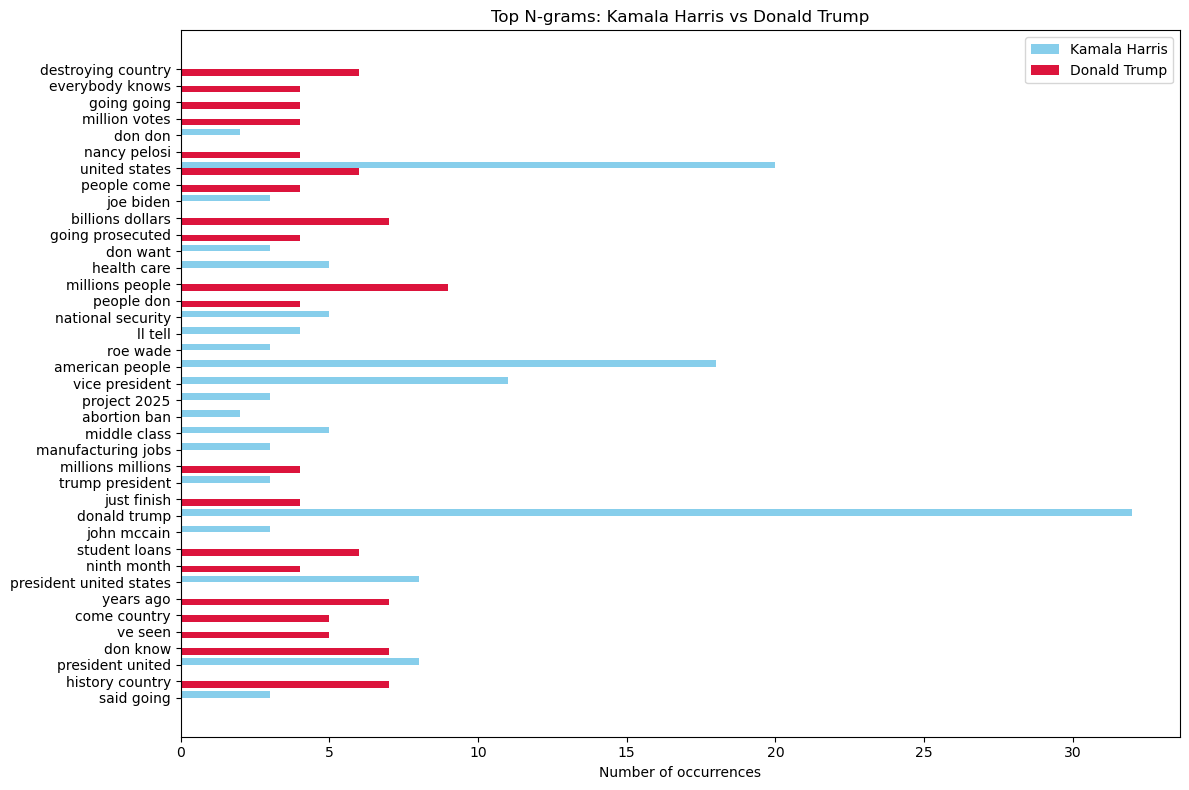

In [22]:
# Top n
top_n = 20
top_trump = dict(sorted(trump_ngram_freq.items(), key=lambda x: x[1], reverse=True)[:top_n])
top_kamala = dict(sorted(kamala_ngram_freq.items(), key=lambda x: x[1], reverse=True)[:top_n])

# Align labels
all_keys = list(set(list(top_trump.keys()) + list(top_kamala.keys())))
trump_vals = [top_trump.get(k, 0) for k in all_keys]
kamala_vals = [top_kamala.get(k, 0) for k in all_keys]

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
y = np.arange(len(all_keys))

ax.barh(y - 0.2, kamala_vals, height=0.4, color='skyblue', label='Kamala Harris')
ax.barh(y + 0.2, trump_vals, height=0.4, color='crimson', label='Donald Trump')

ax.set_yticks(y)
ax.set_yticklabels(all_keys)
ax.invert_yaxis()
ax.set_xlabel('Number of occurrences')
ax.set_title('Top N-grams: Kamala Harris vs Donald Trump')
ax.legend()
plt.tight_layout()
plt.show()